<a href="https://colab.research.google.com/github/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation/blob/main/Detection_of_Healthy_Unhealthy_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import cv2
import numpy as np # dataAnalysis
import pandas as pd #multidimensional arrays
import matplotlib.pyplot as plt #data visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import img_as_ubyte
from skimage.util import img_as_float

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation.git

Cloning into 'Prediction-Recommedation-system-for-Potato-Cultivation'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 232 (delta 79), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (232/232), 64.12 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = os.listdir('/content/drive/MyDrive//Dataset/Training')
classes = {'Healthy':0, 'Virus':1, 'Fungal':2,'Insect':3}

**Image preprocessing and segmentation**

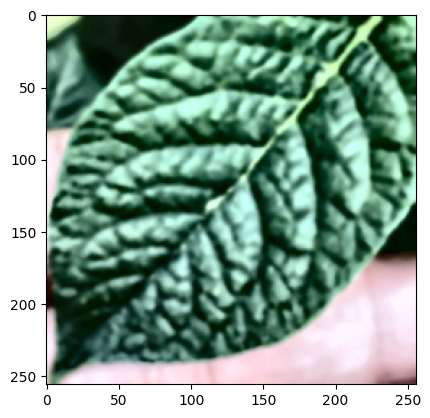

In [ ]:
import cv2
import os
import numpy as np

input_dir = '/content/drive/MyDrive/Dataset/Training/'
output_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the list of transformations
transformations = [
    ('rotation', cv2.ROTATE_90_CLOCKWISE),  # Rotate the image 90 degrees clockwise
    ('translation', np.float32([[1, 0, 50], [0, 1, 50]])),  # Translate the image by 50 pixels in both x and y directions
    ('scaling', np.float32([[0.5, 0, 0], [0, 0.5, 0]])),  # Scale down the image by 0.5
    ('flipping', 0),  # Flip the image horizontally
    ('noise', 30)  # Add Gaussian noise with mean=0 and standard deviation=30
]

x = []
y = []

for cls in classes:
    pth = os.path.join(input_dir, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j))
        img1 = cv2.resize(img, (256, 256))  # Image resizing
        img1 = cv2.medianBlur(img1, 5)  # Apply median filter to remove noise
        img1 = img_as_ubyte(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Contrast improvement

        # Convert the image to LAB color space
        img1_lab = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)

        # Split the LAB image into separate channels
        img1_lab_planes = cv2.split(img1_lab)

        # Apply histogram equalization to the L channel
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = cv2.equalizeHist(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)

        # Merge the planes and convert back to RGB
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Smoothing
        img1 = cv2.GaussianBlur(img1, (5, 5), 0)

        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img1_lab_planes = cv2.split(cv2.cvtColor(img1, cv2.COLOR_RGB2LAB))
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = clahe.apply(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Save preprocessed image
        output_path = os.path.join(output_dir, cls, j)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, img1)

        # Append the preprocessed image and original image to the lists
        x.append(img1)
        y.append(img)

        # Apply transformations to the image
        for transform_name, transform_param in transformations:
            transformed_img = img1.copy()

            if transform_name == 'rotation':
                transformed_img = cv2.rotate(transformed_img, transform_param)
            elif transform_name == 'translation':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (img1.shape[1], img1.shape[0]))
            elif transform_name == 'scaling':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (int(img1.shape[1]*0.5), int(img1.shape[0]*0.5)))
            elif transform_name == 'flipping':
                transformed_img = cv2.flip(transformed_img, transform_param)
            elif transform_name == 'noise':
                noise = np.random.normal(0, transform_param, img1.shape).astype(np.uint8)
                transformed_img = cv2.add(transformed_img, noise)

            # Save the transformed image
            output_path = os.path.join(output_dir, cls, f'{transform_name}_{j}')
            cv2.imwrite(output_path, transformed_img)

# Display the preprocessed image
plt.imshow(x[0])


In [ ]:
print(transformed_img.shape)

(256, 256, 3)


**Feature extraction**

**Texture Properties - energy, ASM, entropy**

**Color Properties - mean hue, mean red, mean green, mean blue, standard deviation hue, standard deviation red, standard deviation green, and standard deviation blue**

In [ ]:
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
import cv2
import os

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
features = []
labels = []

# GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path)

        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        # Compute GLCM properties
        #contrast = greycoprops(glcm, prop='contrast')[0, 0]
        #dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        #homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        energy = greycoprops(glcm, prop='energy')[0, 0]
        #correlation = greycoprops(glcm, prop='correlation')[0, 0]


        # Calculate ASM and entropy
        asm = (glcm**2).sum()
        entropy = shannon_entropy(gray_img)

        # Store the extracted features and labels
        feature = [
            energy,
            asm, entropy,
            mean_hue, mean_red, mean_green, mean_blue,
            std_dev_red, std_dev_green, std_dev_blue
        ]
        features.append(feature)
        labels.append(cls)

# Print the extracted features and labels for each image
for i, feature in enumerate(features):
    print(f"Image {i+1}: Features={feature}, Label={labels[i]}")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version=

Streaming output truncated to the last 5000 lines.
Image 2792: Features=[0.011719516903523174, 0.0001373470764519654, 7.889884340366484, 54.38861083984375, 104.16754150390625, 136.359130859375, 86.442138671875, 74.51303953145089, 73.1183686204318, 65.89567372847179], Label=Virus
Image 2793: Features=[0.3394977816909162, 0.11525874377305305, 6.122200344789235, 33.32066345214844, 69.93832397460938, 90.38824462890625, 54.67242431640625, 79.24080498290876, 88.94598854318575, 64.28182701021439], Label=Virus
Image 2794: Features=[0.014846970672628645, 0.0002204325381538951, 7.898836049400248, 54.488677978515625, 104.30122375488281, 136.634033203125, 86.50637817382812, 74.68469126169022, 73.22251867697047, 65.8094704690039], Label=Virus
Image 2795: Features=[0.01628046904893109, 0.00026505367245320305, 7.834081519377047, 55.433074951171875, 96.89830017089844, 129.9690704345703, 87.85281372070312, 71.25928521626116, 75.40860297158827, 68.59421227967779], Label=Virus
Image 2796: Features=[0.015

In [ ]:
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.feature_selection import f_classif

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
features = []
labels = []

# GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path)

        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        # Compute GLCM properties
        contrast = greycoprops(glcm, prop='contrast')[0, 0]
        dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        energy = greycoprops(glcm, prop='energy')[0, 0]
        correlation = greycoprops(glcm, prop='correlation')[0, 0]

        # Calculate ASM and entropy
        asm = (glcm**2).sum()
        entropy = shannon_entropy(gray_img)

        # Store the extracted features and labels
        feature = [
            contrast, dissimilarity, homogeneity, energy, correlation,
            asm, entropy,
            mean_hue, mean_red, mean_green, mean_blue,
            std_dev_red, std_dev_green, std_dev_blue
        ]
        features.append(feature)
        labels.append(cls)

# Convert features and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Define the feature names
feature_names = [
    "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation",
    "ASM", "Entropy",
    "Mean Hue", "Mean Red", "Mean Green", "Mean Blue",
    "Std Dev Red", "Std Dev Green", "Std Dev Blue"
]

# Perform ANOVA test
f_values, p_values = f_classif(X, y)

# Create a list of tuples containing the feature name, F-value, and p-value
feature_scores = [(feature_names[i], f_val, p_val) for i, (f_val, p_val) in enumerate(zip(f_values, p_values))]

# Sort the feature scores based on the F-values in descending order
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Print the ANOVA test results for each feature
for feature in sorted_feature_scores:
    feature_name, f_val, p_val = feature
    print(f"{feature_name}, : F-value={f_val}, p-value={p_val}")



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

Mean Hue, : F-value=2034.5330221662261, p-value=0.0
Mean Blue, : F-value=264.30686195116186, p-value=2.3107740903201857e-163
Std Dev Green, : F-value=202.39353556910106, p-value=2.0810316213710915e-126
Std Dev Blue, : F-value=119.40174804263596, p-value=1.3280114065749672e-75
Std Dev Red, : F-value=53.37402133634395, p-value=3.846515962125267e-34
Mean Red, : F-value=30.416872486974547, p-value=1.5297894736388063e-19
Entropy, : F-value=26.677368166600314, p-value=3.6869655261283837e-17
ASM, : F-value=24.746654126344485, p-value=6.256542859830248e-16
Mean Green, : F-value=19.9479179715415, p-value=7.090610218105045e-13
Energy, : F-value=19.04034369284162, p-value=2.6779435037599662e-12
Dissimilarity, : F-value=16.06115854282956, p-value=2.0900965253244664e-10
Homogeneity, : F-value=12.45033390808496, p-value=4.045822286397918e-08
Contrast, : F-value=7.572255918167089, p-value=4.69685139704398e-05
Correlation, : F-value=2.196903921647605, p-value=0.08624267280047336


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

**Classification**

In [ ]:
import os
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Specify the file path to save the model
model_path = '/content/drive/MyDrive/Dataset/saved_model.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the trained model to a file
joblib.dump(rf_classifier, model_path)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.9268762026940346
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.98      0.98      0.98       358
     Healthy       0.94      0.87      0.91       428
      Insect       0.96      0.91      0.94       349
       Virus       0.85      0.95      0.90       424

    accuracy                           0.93      1559
   macro avg       0.93      0.93      0.93      1559
weighted avg       0.93      0.93      0.93      1559



/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


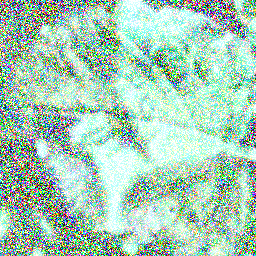

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


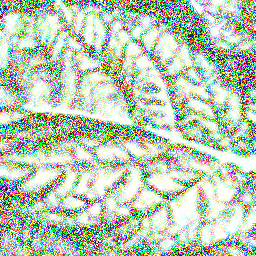

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


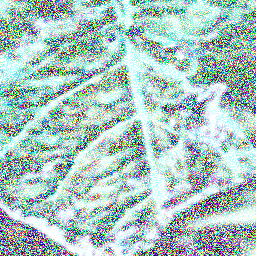

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


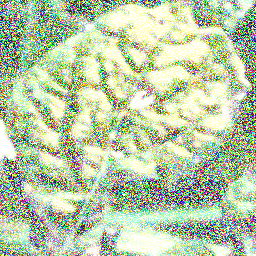

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


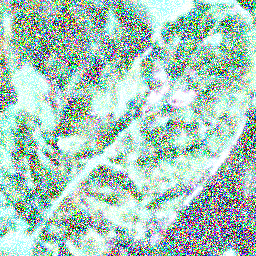

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


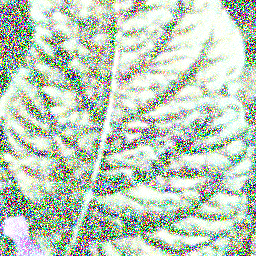

Predicted: Virus


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


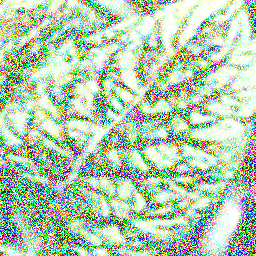

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


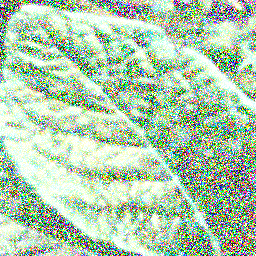

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


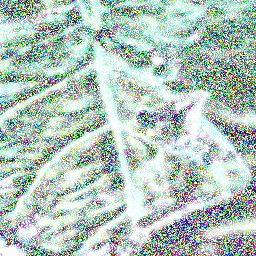

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


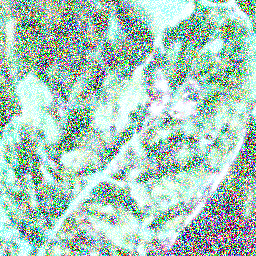

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


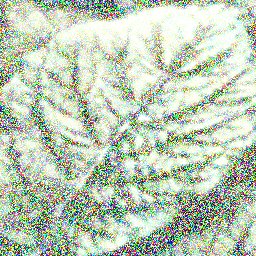

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


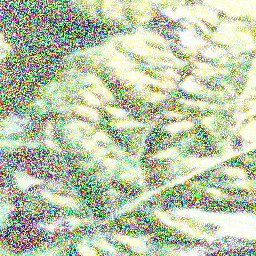

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


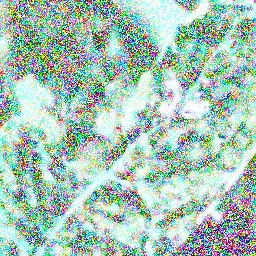

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


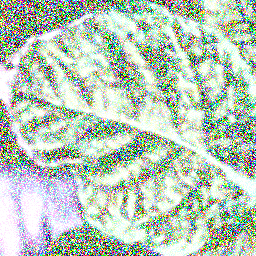

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


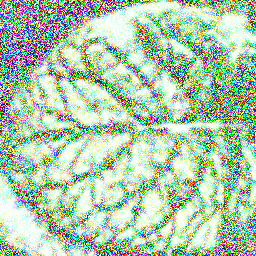

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


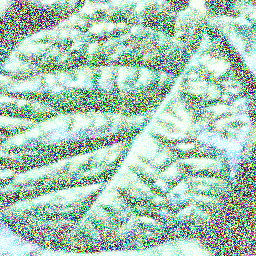

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


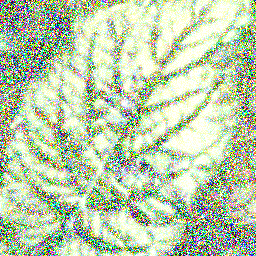

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


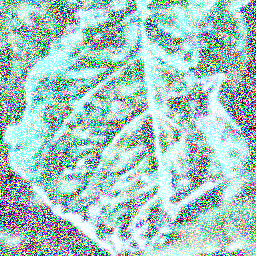

Predicted: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


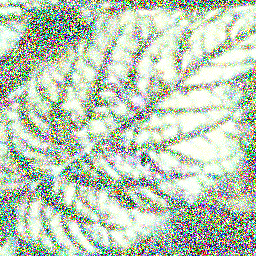

Predicted: Virus


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


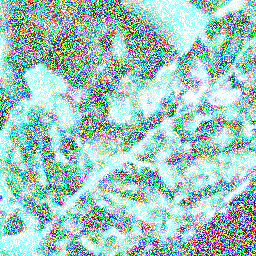

Predicted: Insect


In [23]:
import cv2
import os
import joblib
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from google.colab.patches import cv2_imshow

# Load the trained model
model_path = '/content/drive/MyDrive/Dataset/saved_model.pkl'
rf_classifier = joblib.load(model_path)
classes = {'Fungal':0}

# Directory containing testing images
test_dir = '/content/drive/MyDrive/Dataset/Testing/'

# GLCM parameters
distances = [1]
angles = [0]
testing_features = []
testing_labels = []

# Define the list of transformations
transformations = [
    ('rotation', cv2.ROTATE_90_CLOCKWISE),  # Rotate the image 90 degrees clockwise
    ('translation', np.float32([[1, 0, 50], [0, 1, 50]])),  # Translate the image by 50 pixels in both x and y directions
    ('scaling', np.float32([[0.5, 0, 0], [0, 0.5, 0]])),  # Scale down the image by 0.5
    ('flipping', 0),  # Flip the image horizontally
    ('noise', 30)  # Add Gaussian noise with mean=0 and standard deviation=30
]

# Iterate over the testing images
for cls in classes:
    class_dir = os.path.join(test_dir, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)

        #preprocessing
        img = cv2.resize(img, (256, 256))  # Image resizing
        img = cv2.medianBlur(img, 5)  # Apply median filter to remove noise
        img1 = img_as_ubyte(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Contrast improvement

        # Convert the image to LAB color space
        img1_lab = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)

        # Split the LAB image into separate channels
        img1_lab_planes = cv2.split(img1_lab)

        # Apply histogram equalization to the L channel
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = cv2.equalizeHist(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)

        # Merge the planes and convert back to RGB
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Smoothing
        img1 = cv2.GaussianBlur(img1, (5, 5), 0)

        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img1_lab_planes = cv2.split(cv2.cvtColor(img1, cv2.COLOR_RGB2LAB))
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = clahe.apply(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Apply transformations to the image
        for transform_name, transform_param in transformations:
            transformed_img = img1.copy()

            if transform_name == 'rotation':
                transformed_img = cv2.rotate(transformed_img, transform_param)
            elif transform_name == 'translation':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (img1.shape[1], img1.shape[0]))
            elif transform_name == 'scaling':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (int(img1.shape[1]*0.5), int(img1.shape[0]*0.5)))
            elif transform_name == 'flipping':
                transformed_img = cv2.flip(transformed_img, transform_param)
            elif transform_name == 'noise':
                noise = np.random.normal(0, transform_param, img1.shape).astype(np.uint8)
                img = cv2.add(transformed_img, noise)


        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        energy = greycoprops(glcm, prop='energy')[0, 0]

        # Calculate ASM and entropy
        asm = (glcm ** 2).sum()
        entropy = shannon_entropy(gray_img)

        # Store the extracted features
        features = [
            energy,
            asm,
            entropy,
            mean_hue,
            mean_red,
            mean_green,
            mean_blue,
            std_dev_red,
            std_dev_green,
            std_dev_blue
        ]
        testing_features.append(features)
        testing_labels.append(cls)

        # Convert the features to a numpy array
        features = np.array(features)

        # Reshape the feature array to match the input shape expected by the model
        features = features.reshape(1, -1)

        # Make predictions using the trained model
        predicted_label = rf_classifier.predict(features)[0]

        # Display the image with the predicted label
        cv2_imshow(img)
        print('Predicted:', predicted_label)



Accuracy: 0.9230275817831943
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.99      0.96      0.98       358
     Healthy       0.93      0.86      0.89       428
      Insect       0.95      0.93      0.94       349
       Virus       0.85      0.94      0.89       424

    accuracy                           0.92      1559
   macro avg       0.93      0.93      0.93      1559
weighted avg       0.93      0.92      0.92      1559



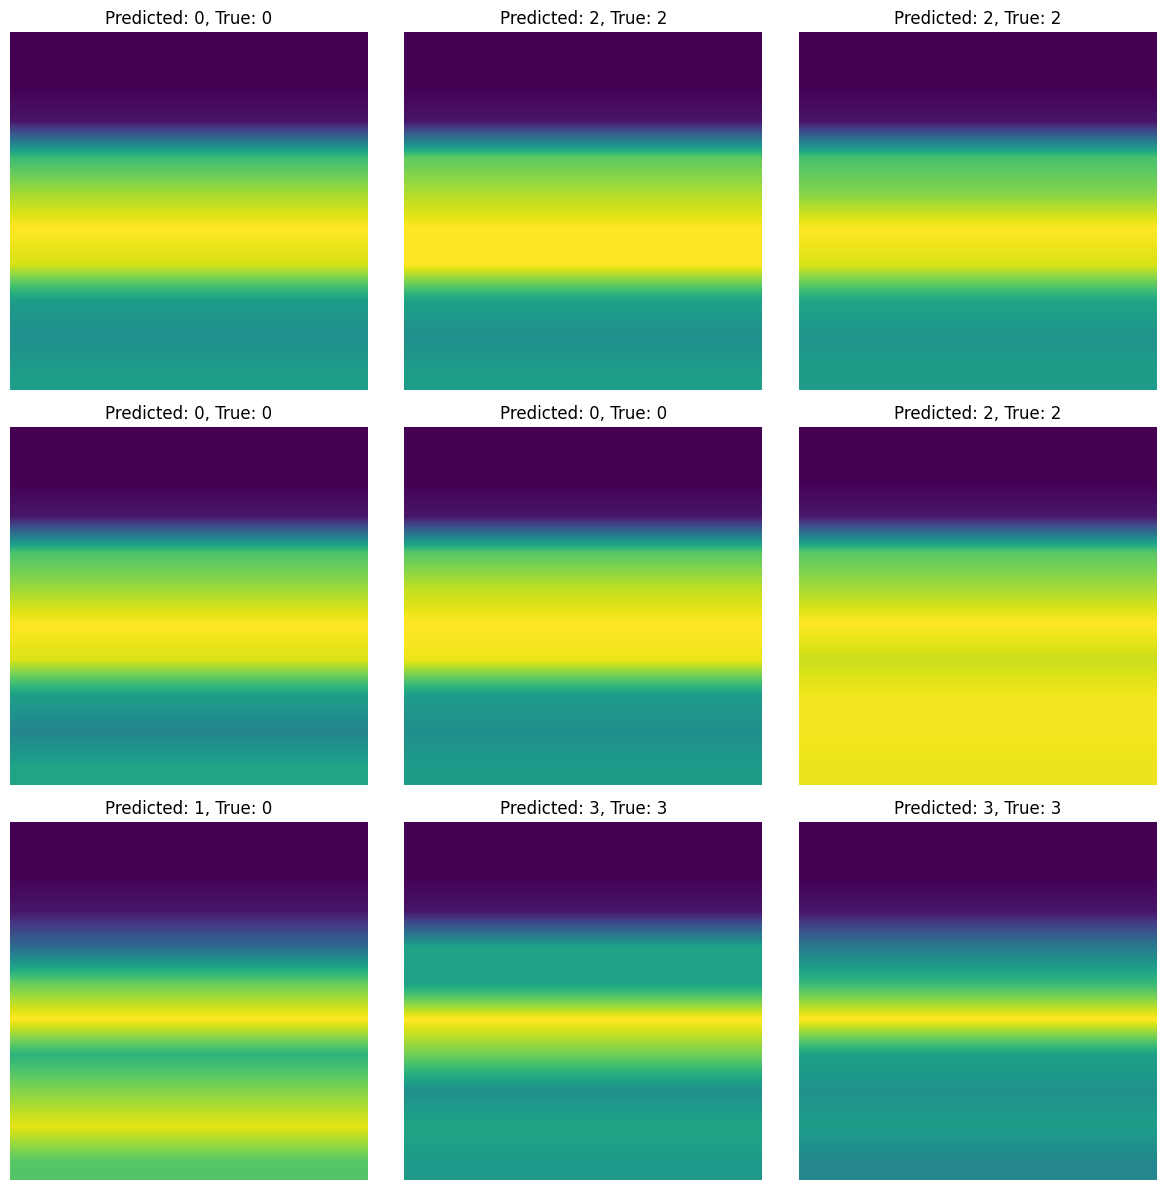

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)

# Define the class names corresponding to the predicted labels using a dictionary
class_names = {'Healthy':0, 'Virus':1, 'Fungal':2,'Insect':3}

# Visualize the images with their predicted labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    img_index = i  # Index of the image to display
    img = cv2.resize(X_test[img_index], (256, 256))  # Resize the image to (256, 256)
    pred_label = y_pred[img_index]  # Retrieve the predicted label
    true_label = y_test[img_index]  # Retrieve the true label
    pred_class_name = class_names[pred_label]  # Convert the predicted label to class name
    true_class_name = class_names[true_label]  # Convert the true label to class name
    ax.imshow(img)
    ax.set_title("Predicted: {}, True: {}".format(pred_class_name, true_class_name))
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.8749198203976908
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.96      0.96      0.96       358
     Healthy       0.85      0.84      0.85       428
      Insect       0.89      0.86      0.88       349
       Virus       0.82      0.85      0.83       424

    accuracy                           0.87      1559
   macro avg       0.88      0.88      0.88      1559
weighted avg       0.88      0.87      0.88      1559



In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset
X = np.array(features)  # Features matrix
y = np.array(labels)  # Target vector (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
clf = svm.SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Evaluate the model
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.6779987171263631
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.87      0.94      0.90       358
     Healthy       0.89      0.41      0.56       428
      Insect       0.67      0.52      0.59       349
       Virus       0.52      0.86      0.65       424

    accuracy                           0.68      1559
   macro avg       0.74      0.68      0.67      1559
weighted avg       0.73      0.68      0.67      1559



In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.8422065426555484
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.96      0.97      0.96       358
     Healthy       0.82      0.79      0.80       428
      Insect       0.81      0.86      0.83       349
       Virus       0.80      0.77      0.78       424

    accuracy                           0.84      1559
   macro avg       0.84      0.85      0.85      1559
weighted avg       0.84      0.84      0.84      1559

